In [9]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample
from metrics import Pearson

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [2]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir, sub_mean=False):
    cgm, meals = pre.get_dfs(data_dir)
    if sub_mean:
        mean, std = pre.norm_stats['GlucoseValue']
        cgm['GlucoseValue'] = cgm['GlucoseValue'] - mean / std
        
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y
    
class AddNoise(Callback):
    
    def __init__(self, std):
        self.std = std
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            return
        
        size = last_input.shape[0], last_input.shape[2]
        noise = torch.normal(0, self.std, size).to(last_input.device)
        last_input[:, -2] += noise
        return {'last_input': last_input}


In [3]:
train_data = get_data(train)
val_data = get_data(val)
train_data[1].head()

/home/labs/waic/omrik/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


weight  alanine_g  alcohol_g  arginine_g  caffeine_mg  \
id Date                                                                         
46 2015-01-05 10:18:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:33:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:48:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:03:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:18:00     0.0        0.0        0.0         0.0          0.0   

                        calcium_mg  carbohydrate_g  cholesterol_mg  \
id Date                                                              
46 2015-01-05 10:18:00         0.0             0.0             0.0   
   2015-01-05 10:33:00         0.0             0.0             0.0   
   2015-01-05 10:48:00         0.0             0.0             0.0   
   2015-01-05 11:03:00         0.0             0.0             0.0   
   2015-01-05 11:18:00         0.0             0.0             0.0   

                        energy_kcal  fructose_g  ...  \
id Date                                          ...   
46 2015-01-05 10:18:00          0.0         0.0  ...   
   2015-01-05 10:33:00          0.0         0.0  ...   
   2015-01-05 10:48:00          0.0         0.0  ...   
   2015-01-05 11:03:00          0.0         0.0  ...   
   2015-01-05 11:18:00          0.0         0.0  ...   

                        totalpolyunsaturatedfattyacids_g  \
id Date                                                    
46 2015-01-05 10:18:00                               0.0   
   2015-01-05 10:33:00                               0.0   
   2015-01-05 10:48:00                               0.0   
   2015-01-05 11:03:00                               0.0   
   2015-01-05 11:18:00                               0.0   

                        totalsaturatedfattyacids_g  totaltransfattyacids_g  \
id Date                                                                      
46 2015-01-05 10:18:00                         0.0                     0.0   
   2015-01-05 10:33:00                         0.0                     0.0   
   2015-01-05 10:48:00                         0.0                     0.0   
   2015-01-05 11:03:00                         0.0                     0.0   
   2015-01-05 11:18:00                         0.0                     0.0   

                        vitaminc_mg  vitamind_iu  vitamine_mg  water_g  \
id Date                                                                  
46 2015-01-05 10:18:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:33:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:48:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:03:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:18:00          0.0          0.0          0.0      0.0   

                        zinc_mg  GlucoseValue      time  
id Date                                                  
46 2015-01-05 10:18:00      0.0      6.647964  0.429167  
   2015-01-05 10:33:00      0.0      6.465828  0.439583  
   2015-01-05 10:48:00      0.0      6.101556  0.450000  
   2015-01-05 11:03:00      0.0      6.010488  0.460417  
   2015-01-05 11:18:00      0.0      6.192624  0.470833  

[5 rows x 38 columns]

In [4]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7f0ef2ef49e8>;

Valid: <__main__.ContData object at 0x7f0ef2ef4fd0>;

Test: None

In [7]:
class Seq2Seq(Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super().__init__()
        self.encoder = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, 8)
        
    def forward(self, input):
        device = input.device
        bs = input.shape[0]
        input = input.transpose(0, 1)
        
        encoder_outputs, hidden = self.encoder(input)
        out = self.decoder(encoder_outputs)
        return out

In [10]:
model = Seq2Seq(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 5.75E-03


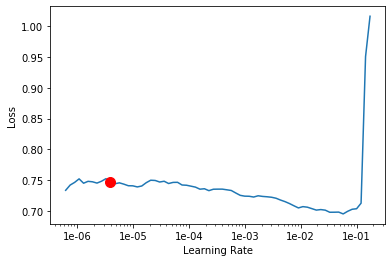

In [11]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [12]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.483524,0.472392,0.461293,0.581867,09:18
1,0.449892,0.444934,0.469877,0.609282,09:10
2,0.434395,0.426017,0.447468,0.620813,08:54
3,0.433936,0.422985,0.440998,0.623437,08:57
4,0.427195,0.421187,0.445534,0.626120,08:32
5,0.419408,0.420841,0.446560,0.626385,08:34
6,0.406240,0.419284,0.441407,0.628534,08:29
7,0.404658,0.421339,0.443527,0.625668,09:33


KeyboardInterrupt: 

In [14]:
model = Seq2Seq(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=loss, metrics=metrics)

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: expand(torch.cuda.FloatTensor{[512, 1, 8]}, size=[512, 8]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [ ]:
learner.fit_one_cycle(10, 1e-3)